In [27]:
import pandas as pd
import time
from collections import Counter
from nltk import word_tokenize 
# https://www.nltk.org/_modules/nltk/tokenize.html
# Tokenizers divide strings into lists of substrings.  For example,
# tokenizers can be used to find the words and punctuation in a string
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pickle

import datetime # for time of year
import json # string processing
import os # for I/O
import sys # see memory usage

from sklearn.feature_extraction.text import CountVectorizer 
# see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Convert a collection of text documents to a matrix of token counts
#This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import svm

In [28]:
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

def my_preprocess(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # Step 1: transfer data to lower-case strings
    list_words = word_tokenize(sentence) #Step 2: break the sentences into a list of words
    list_words = remove_values_from_list(list_words, '$') # Step 3: $hashtag$ and $url$ must be filtered
    list_words = remove_values_from_list(list_words, 'hashtag')
    list_words = remove_values_from_list(list_words, 'url')
    # Step 4: filter punctuations
    list_words_return = []
    for s in list_words:
        if s not in string.punctuation:
            list_words_return.append(s)
    # Step 5: some rows might disapear, I give " " to them
    if len(list_words_return) == 0:
        list_words_return.append(" ")
    return (' '.join(list_words_return)) # return a string which words seperated by ' '

def my_preprocess2(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # Step 1: transfer data to lower-case strings
    list_words = word_tokenize(sentence) #Step 2: break the sentences into a list of words
    list_words = remove_values_from_list(list_words, '$') # Step 3: $hashtag$ and $url$ must be filtered
    list_words = remove_values_from_list(list_words, 'hashtag')
    list_words = remove_values_from_list(list_words, 'url')
    # Step 4: filter punctuations
    list_words_return = []
    for s in list_words:
        if s not in string.punctuation:
            list_words_return.append(s)
    # Step 5: some rows might disapear, I give " " to them
    if len(list_words_return) == 0:
        list_words_return.append(" ")
    return (list_words_return) # return a list of words

def fit_model(model,train_features,test_features,y_train,y_test):
    model.fit(train_features,y_train)
    acc = model.score(test_features,y_test)
    predictions = model.predict(test_features)
    cm = metrics.confusion_matrix(y_test, predictions)
    if (cm[0][0] + cm[0][1] == 0):
        pre = 0
    else:
        pre = (cm[0][0]+0.0) / (cm[0][0] + cm[0][1])
    if (cm[0][0] + cm[1][0] == 0):
        rec = 0
    else:    
        rec = (cm[0][0]+0.0) / (cm[0][0] + cm[1][0])
    
    return acc,pre,rec

def print_dict(dictionary):
    for key,value in dictionary.items():
        print(key,"  ","  ".join(str(round(x,3)) for x in value))
    return None

# read in json files, do string processing

In [3]:
def extract_date(string):
    data_time_obj = parser.parse(string)
    return ([data_time_obj.year, data_time_obj.month, data_time_obj.day]) # acess by '.year', '.month', '.day'

### process json file names, extract handle names

In [5]:
start_time = time.time()
path = "/mnt/c/Users/Administrator.DESKTOP-OHBO1TS/Desktop/github/BlockchainTweetAnalyses-master/" + \
"BlockchainTweetAnalyses-master/training_data/"
path2 = "/mnt/c/Users/Administrator.DESKTOP-OHBO1TS/Desktop/github/BlockchainTweetAnalyses-master/" + \
"BlockchainTweetAnalyses-master/Tweet-Data/raw_tweet_data/"

all_file_names = os.listdir(path2)
all_handle_names = []

# detect "_" + somenumber (from 0 to 20)
stopwords = []
for i in range(20):
    stopwords.append('_' + str(i))

# get the handle names
for file_name in all_file_names:
    i = 0
    find_flag = False
    while (i <= len(stopwords)):
        pos = file_name.find(stopwords[i])
        if pos != -1:
            find_flag = True
            break
        i+=1
    if find_flag: # find "_" + somenumber (from 0 to 99)
        all_handle_names.append(file_name[0:pos])
    else:
        print("unable to find handle name for ", file_name)
        all_handle_names.append(-1) # -1 means wrong

assert len(all_handle_names) == len(all_file_names), "file names and handle names must have same length!"
print("this cell takes time:",round(time.time() - start_time,3),"s")

this cell takes time: 0.783 s


### deal with each json file, extract 'created_at' and put in datetime structure
### also extract 'id' and 'full_text'

In [176]:
# save all data into a dictionary, its key is handle name, then in 2nd layer the key is ['id'], 
# and value is ['created_at','full_text']. In the future, I will add predictions in 2nd layer
start_time = time.time()
all_data_dict = dict()
second_layer_dict = dict()
handle_prev = -1 
handle_count = 0 # save each 1000 handles into file, or my memory will explode....
file_count_global = 0
print("=====I need to deal with ",len(all_handle_names),"=====files")

for i in range(len(all_file_names)): # read in all files
#for i in range(1100):
    if (i % 100) == 0: # save the dict file every 500 rows, otherwise my memory will explode...
        print("finished proceed ",i," files")
        print("all_data_dict uses space: ",sys.getsizeof(all_data_dict), " bytes")
        
    handle_curr = all_handle_names[i]
    #print("i=",i," handle_curr=",handle_curr," handle_prev=",handle_prev)
    if handle_prev!=-1 and handle_curr != handle_prev: # detect a different handle
        all_data_dict[handle_prev] = second_layer_dict # give the 2nd layer dict to 1st layer dict
        second_layer_dict = dict() # clean dict
        handle_count+=1
        if handle_count!=0 and handle_count % 1000 == 0: # save each 1000 handle info into file
            # Store data (serialize)
            file_count_global += 1
            print("i=",i," handle_count=",handle_count," file_count_global=",file_count_global)
            with open(path + str(file_count_global) + '_dict.pickle', 'wb') as handle:
                pickle.dump(all_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
            all_data_dict = dict()
            
    # working on current handle
    with open(path2+all_file_names[i]) as f:
        data = json.load(f)
        for item in data: # each data contains around 200 dicts (item)
            second_layer_dict[item['id']] = {'created_at':extract_date(item['created_at']),\
                                             'full_text':my_preprocess(item['full_text'])}
    f.close()
    # update handle
    handle_prev = handle_curr
# end of for-loop
            
# pass the last handle info after for-loop
all_data_dict[handle_prev] = second_layer_dict # give the 2nd layer dict to 1st layer dict

# save the last few handles into file for memory issue
file_count_global += 1
print("i=",i," handle_count=",handle_count," file_count_global=",file_count_global)
with open(path + str(file_count_global) + '_dict.pickle', 'wb') as handle:
    pickle.dump(all_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("this cell takes time:",round(time.time() - start_time,3),"s")

# show the first and last item of the dict
print("first handle",list(all_data_dict.keys())[0]," last handle",list(all_data_dict.keys())[-1])

=====I need to deal with  25031 =====files
finished proceed  0  files
all_data_dict uses space:  240  bytes
finished proceed  100  files
all_data_dict uses space:  1184  bytes
finished proceed  200  files
all_data_dict uses space:  2280  bytes
finished proceed  300  files
all_data_dict uses space:  4704  bytes
finished proceed  400  files
all_data_dict uses space:  4704  bytes
finished proceed  500  files
all_data_dict uses space:  4704  bytes
finished proceed  600  files
all_data_dict uses space:  9320  bytes
finished proceed  700  files
all_data_dict uses space:  9320  bytes
finished proceed  800  files
all_data_dict uses space:  9320  bytes
finished proceed  900  files
all_data_dict uses space:  9320  bytes
finished proceed  1000  files
all_data_dict uses space:  9320  bytes
finished proceed  1100  files
all_data_dict uses space:  18528  bytes
finished proceed  1200  files
all_data_dict uses space:  18528  bytes
finished proceed  1300  files
all_data_dict uses space:  18528  bytes
f

finished proceed  11500  files
all_data_dict uses space:  9320  bytes
finished proceed  11600  files
all_data_dict uses space:  9320  bytes
finished proceed  11700  files
all_data_dict uses space:  9320  bytes
finished proceed  11800  files
all_data_dict uses space:  9320  bytes
finished proceed  11900  files
all_data_dict uses space:  9320  bytes
finished proceed  12000  files
all_data_dict uses space:  18528  bytes
finished proceed  12100  files
all_data_dict uses space:  18528  bytes
finished proceed  12200  files
all_data_dict uses space:  18528  bytes
finished proceed  12300  files
all_data_dict uses space:  18528  bytes
finished proceed  12400  files
all_data_dict uses space:  18528  bytes
finished proceed  12500  files
all_data_dict uses space:  18528  bytes
finished proceed  12600  files
all_data_dict uses space:  18528  bytes
finished proceed  12700  files
all_data_dict uses space:  18528  bytes
finished proceed  12800  files
all_data_dict uses space:  18528  bytes
finished pr

finished proceed  22900  files
all_data_dict uses space:  18528  bytes
finished proceed  23000  files
all_data_dict uses space:  18528  bytes
finished proceed  23100  files
all_data_dict uses space:  18528  bytes
finished proceed  23200  files
all_data_dict uses space:  18528  bytes
finished proceed  23300  files
all_data_dict uses space:  18528  bytes
finished proceed  23400  files
all_data_dict uses space:  18528  bytes
finished proceed  23500  files
all_data_dict uses space:  18528  bytes
finished proceed  23600  files
all_data_dict uses space:  36968  bytes
finished proceed  23700  files
all_data_dict uses space:  36968  bytes
finished proceed  23800  files
all_data_dict uses space:  36968  bytes
finished proceed  23900  files
all_data_dict uses space:  36968  bytes
finished proceed  24000  files
all_data_dict uses space:  36968  bytes
finished proceed  24100  files
all_data_dict uses space:  36968  bytes
finished proceed  24200  files
all_data_dict uses space:  36968  bytes
finish

### read in sampled handles

In [6]:
# read in sample data
start_time = time.time()
path3 = "/mnt/c/Users/Administrator.DESKTOP-OHBO1TS/Desktop/github/"
df_high = pd.read_excel(path3 + "sample_handles.xlsx",sheet_name='sample_high_performing')
print("df_high.shape",df_high.shape)

df_low = pd.read_excel(path3 + "sample_handles.xlsx",sheet_name='sample_low_performing')
print("df_low.shape",df_low.shape)
print("this cell takes time:",round(time.time() - start_time,3),"s")

df_high.shape (41, 3)
df_low.shape (41, 3)
this cell takes time: 0.216 s


In [7]:
df_high.head()

CoinNames          Handle  Tweets
0       Dash         dashpay    3244
1     Ripple          ripple    3241
2  Aeternity       aeternity    3233
3    Horizen   horizenglobal    3231
4       TRON  tronfoundation    3229

# Predict labels according to my models

### read in bag_of_words and intialize word model

In [8]:
# read bag of words
bag_of_words = list()

f = open(path +  'Zhiyuan_Li_word_dict.csv','r')
for x in f.readlines():
    #x.replace("\t", "")
    #x.replace("\n", "")
    bag_of_words.append(x[0:-1])
f.close()
print("finished reading bag_of_words")

Zhiyuan_count_vec = CountVectorizer(analyzer = "word",vocabulary=bag_of_words)
print("Initialize Zhiyuan_count_vec")

assert len(bag_of_words) == len(np.unique(bag_of_words)), "bag_of_words must be unique dict of words!"

finished reading bag_of_words
Initialize Zhiyuan_count_vec


### get file names to be processed

In [9]:
all_file_names = os.listdir(path)
pickle_file_names = []
model_file_names = []

# get all picle files
for file_name in all_file_names:
    if file_name.find('.pickle') != -1:
        pickle_file_names.append(file_name)
    elif file_name.find('.sav') != -1:
        model_file_names.append(file_name)
        
print("pickle_file_names",pickle_file_names)
print("model_file_names",model_file_names)

pickle_file_names ['1_dict.pickle', '2_dict.pickle', '3_dict.pickle', '4_dict.pickle', '5_dict.pickle', '6_dict.pickle', '7_dict.pickle', '8_dict.pickle']
model_file_names ['Build own community_model_NB.sav', 'Collaborate with new players_model_LR.sav', 'Complement traditional players_model_RF.sav', 'Differentiate from new players_model_LR.sav', 'Differentiation without a Comparison_model_RF.sav', 'Disrupt traditional players_model_LR.sav', 'Legitimation from Government Regulations_model_RF.sav', 'Media coverage_model_RF.sav', 'Project Progress Updates_model_RF.sav']


### get the models and make prediction

In [10]:
def sort_dict_by_key_date(diction):
    from datetime import datetime
    diction_new = dict()
    #keys = list( diction.keys() )
    #dates = [datetime.strptime(ts, "%Y-%m-%d") for ts in keys]
    dates = sorted(diction.keys())
    for tup in dates:
        date = [tup.year,tup.month,tup.day]
        key = '-'.join([str(i) for i in date])
        key2 = "{:%m/%d/%Y}".format(tup)
        diction_new.update({tup:diction[tup]})
        #diction_new.update({key:diction[key]})
    return diction_new

### compute total tweets

In [11]:
total_length = 0
for file_name in pickle_file_names: # loop over the whole data which is seperated into 9 pickle files and words filtered
    with open(path+file_name, 'rb') as handle:
        data_dict = pickle.load(handle)
    handle.close()
    for key in data_dict.keys(): # loop over each handle
        for ids,values in data_dict[key].items(): # loop over each message for 1 handle
            total_length+=1
print(total_length)

4098823


#### 'Build own community'

In [569]:
# now I do not care ID, I only care: handle, date, predictions. Hence, the top level is date, then
# the key at second level is handle, at second level the value is a list predictions append to them
start_time = time.time()
category = 'Build own community'

for name in model_file_names: # loop over 9 categories with their ML models
    # referred from https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
    if category in name:
        loaded_model = pickle.load(open(path+name, 'rb'))
        print("load_model:",loaded_model)
        
final_result_dict = dict()
for file_name in pickle_file_names: # loop over the whole data which is seperated into 9 pickle files and words filtered
    with open(path+file_name, 'rb') as handle:
        data_dict = pickle.load(handle)
    handle.close()
        
    # start prediction
    for key in data_dict.keys(): # loop over each handle
        if key in list(df_high['Handle']) or key in list(df_low['Handle']):
            handle_name = key
            prediction_result = list() # initialization
            time_lst = list()
            for ids,values in data_dict[key].items(): # loop over each message for 1 handle
                all_features = Zhiyuan_count_vec.fit_transform([values['full_text']])
                prediction_result.append( int(loaded_model.predict(all_features)) )
                time0 = '-'.join([str(i) for i in values['created_at']]) # turn (2019,7,5) to 2019-7-5
                time_lst.append(time0)

            # group date-prediction dict
            date_predict_dict = dict()
            for j in range(len(time_lst)):
                date = time_lst[j]
                one_prediction = prediction_result[j]
                if date in date_predict_dict.keys():
                    date_predict_dict[date].append(one_prediction)
                else:
                    date_predict_dict.update({date:[one_prediction]}) # initialization

            #print("handle=",handle_name," category=",category," date_predict_dict=", date_predict_dict)
            print("*** dealt handle=",handle_name)
            if handle_name in final_result_dict.keys():
                assert 0, "I cannot have repeative handles as key!"
            else:
                final_result_dict.update({handle_name:date_predict_dict})
    # end of inner-loop
    print("===== finished prediction with ",file_name)
# end of outter-loop

print("this cell takes time:",round(time.time() - start_time,3),"s")

AttributeError: 'str' object has no attribute 'time'

In [563]:
high_result_dict = dict() # key is time, value is 0/1
low_result_dict = dict() # key is time, value is 0/1

for handle,nest_dict in final_result_dict.items():
    if handle in list(df_high['Handle']):
        for time,prediction_lst in nest_dict.items():
            if time in high_result_dict.keys(): # aready have
                for prediction in prediction_lst:
                    high_result_dict[time].append(prediction)
            else:
                high_result_dict.update({time:prediction_lst})
                
    elif handle in list(df_low['Handle']):
        for time,prediction_lst in nest_dict.items():
            if time in low_result_dict.keys(): # aready have
                for prediction in prediction_lst:
                    low_result_dict[time].append(prediction)  
            else:
                low_result_dict.update({time:prediction_lst})
    else:
        print("Wrong, find strange handle= ",handle)

In [564]:
print("len(low_result_dict)=",len(low_result_dict))
print("len(high_result_dict)=",len(high_result_dict))

len(low_result_dict)= 3273
len(high_result_dict)= 2208


In [567]:
low_result_dict = sort_dict_by_key_date(diction=low_result_dict)
high_result_dict = sort_dict_by_key_date(diction=high_result_dict)
df_low_result = pd.DataFrame(list(low_result_dict.items()), columns=['Date', 'prediction']) 
df_low_result.index = df_low_result['Date']  # Set the datetime column as the index
df_high_result = pd.DataFrame(list(high_result_dict.items()), columns=['Date', 'prediction']) 
df_high_result.index = df_high_result['Date'] # Set the datetime column as the index

AttributeError: 'str' object has no attribute 'year'

In [558]:
df_low_result.head()

Date       prediction
Date                                 
2008-3-14  2008-3-14        [0, 0, 0]
2008-3-17  2008-3-17     [0, 0, 0, 0]
2008-3-18  2008-3-18  [0, 0, 0, 0, 0]
2008-3-19  2008-3-19     [0, 0, 0, 0]
2008-3-20  2008-3-20           [0, 0]

In [559]:
df_high_result.head()

Date prediction
Date                           
2013-6-27  2013-6-27     [0, 0]
2013-6-28  2013-6-28     [0, 0]
2013-6-29  2013-6-29        [0]
2013-6-30  2013-6-30        [1]
2013-7-1    2013-7-1     [0, 0]

In [12]:
def get_month_average(df_result):
    index_prev = -1
    prediction = list()
    month_lst = list()
    result_lst = list()

    for index, row in df_result.iterrows():
        if index_prev != -1 and index_prev != index.month: # find a new month, get result of previous month
            month_lst.append( str(row['Date'].year) + '-' + str(index_prev) )
            result_lst.append( np.mean(prediction) )
            prediction = list()

        # append result
        for data in row['prediction']:
            prediction.append(data)
        index_prev = index.month
    
    return month_lst,result_lst

In [16]:
category = 'Build own community'

month_low_lst,result_low_lst   = get_month_average(df_result=df_low_result)
month_high_lst,result_high_lst = get_month_average(df_result=df_high_result)

df_low_result.to_csv(path + category + '_df_low_result.csv') 
df_high_result.to_csv(path + category + '_df_high_result.csv') 

file = open(path + category + '_plot.pkl','wb')
pickle.dump(month_low_lst, file)
pickle.dump(month_high_lst, file)
pickle.dump(result_low_lst, file)
pickle.dump(result_high_lst, file)
file.close()
print("***** 4 lists have been saved as pickles!!! *****")

NameError: name 'df_low_result' is not defined

In [29]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_figure(category,path,month_lst,result_lst,title_text='HIGH performing'):
    plt.figure(figsize=(12,8))
    plt.title(category + " " + title_text,fontsize="x-large")
    if title_text == 'HIGH performing':
        plt.plot(month_lst,result_lst,'ro--')
        plt.plot(month_lst, smooth(result_lst,4), 'b--',lw=3)
    else:
        plt.plot(month_lst,result_lst,'ko--')
        plt.plot(month_lst, smooth(result_lst,4), 'b--',lw=3)
    
    #plt.xlim(['2008-6','2019-6'])
    plt.ylabel('Prediction',fontsize=12)
    plt.legend(['prediction every month','average smoothing for every season'],fontsize=12)
    #locs, labels = plt.xticks()
    plt.xticks(np.arange(0, len(month_lst), 12))
    plt.grid(color='grey', linestyle='--')
    plt.savefig(path+category+title_text+"old.png")
    plt.show()

    # deal with this function at daytime!!!!!!!
def plot_figure_aug(category,path,month_lst,result_lst,title_text='HIGH performing',ymax=0.1):
    month_lst_start = '2013-6'
    month_lst_end = '2019-6'
    list_of_month = pd.date_range(month_lst_start,month_lst_end, 
              freq='MS').strftime("%Y-%m").tolist()
    month_lst_final = []
    result_lst_final = []
    for i in range(len(list_of_month)):
        mon = list_of_month[i]
        month_lst_final.append(mon)
        if mon in month_lst:
            index = month_lst.index(mon)
            result_lst_final.append(result_lst[index])
        else:
            result_lst_final.append(0)
    
    month_lst = month_lst_final
    result_lst = result_lst_final
    
    plt.figure(figsize=(12,8))
    plt.title(category + " " + title_text,fontsize="x-large")
    if title_text == 'HIGH performing':
        plt.plot(month_lst,result_lst,'ro--')
        plt.plot(month_lst, smooth(result_lst,4), 'b--',lw=3)
    else:
        plt.plot(month_lst,result_lst,'ko--')
        plt.plot(month_lst, smooth(result_lst,4), 'y--',lw=3)
    plt.ylim((0, ymax))    
    plt.ylabel('Prediction',fontsize=12)
    plt.legend(['prediction every month','average smoothing for every season'],fontsize=12)
    #locs, labels = plt.xticks()
    plt.xticks(np.arange(min(x), max(x)+len(month_lst), 12))
    plt.grid(color='grey', linestyle='--')
    plt.savefig(path+category+title_text+".png")
    plt.show()

    plt.figure(figsize=(12,8))
    plt.title(category + " " + title_text+"_seaonal trend",fontsize="x-large")
    if title_text == 'HIGH performing':
        plt.plot(month_lst, smooth(result_lst,4), 'b--',lw=3)
    else:
        plt.plot(month_lst, smooth(result_lst,4), 'y--',lw=3)
    plt.ylim((0, round(ymax/4*3,3)))   
    plt.ylabel('Prediction',fontsize=12)
    plt.legend(['average smoothing for every season'],fontsize=12)
    #locs, labels = plt.xticks()
    plt.xticks(np.arange(min(x), max(x)+len(month_lst), 12))
    plt.grid(color='grey', linestyle='--')
    plt.savefig(path+category+title_text+"_seaonal_trend.png")
    plt.show()

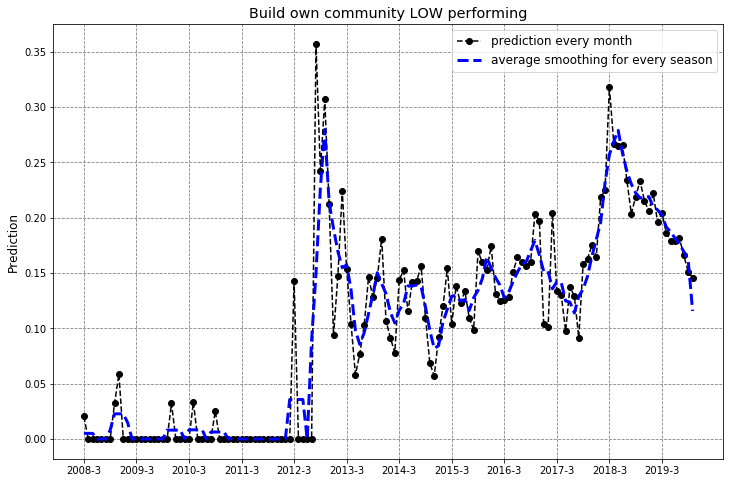

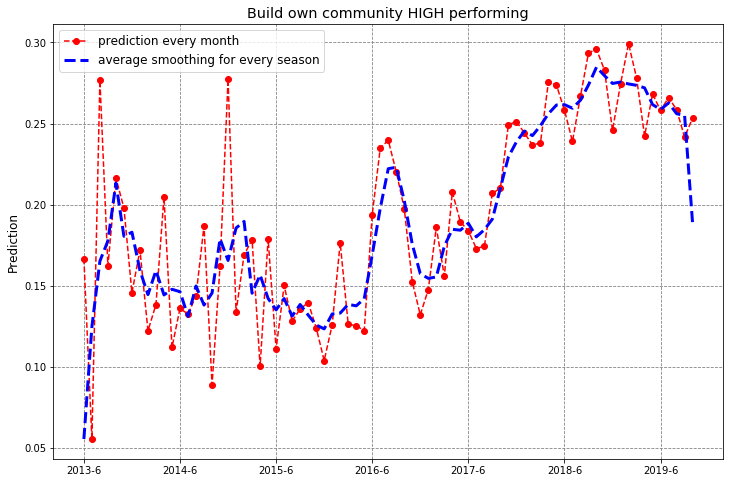

In [30]:
category = 'Build own community'

# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')

### I finished dealing with 1 category, will write these codes as function and loop and do later

In [503]:
def get_prediction_result(category,path): 
    # now I do not care ID, I only care: handle, date, predictions. Hence, the top level is date, then
    # the key at second level is handle, at second level the value is a list predictions append to them
    start_time = time.time()

    for name in model_file_names: # loop over 9 categories with their ML models
        # referred from https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
        if category in name:
            loaded_model = pickle.load(open(path+name, 'rb'))
            print("load_model:",loaded_model)

    final_result_dict = dict()
    for file_name in pickle_file_names: # loop over the whole data which is seperated into 9 pickle files and words filtered
        with open(path+file_name, 'rb') as handle:
            data_dict = pickle.load(handle)
        handle.close()

        # start prediction
        for key in data_dict.keys(): # loop over each handle
            if key in list(df_high['Handle']) or key in list(df_low['Handle']):
                handle_name = key
                prediction_result = list() # initialization
                time_lst = list()
                for ids,values in data_dict[key].items(): # loop over each message for 1 handle
                    all_features = Zhiyuan_count_vec.fit_transform([values['full_text']])
                    prediction_result.append( int(loaded_model.predict(all_features)) )
                    time0 = '-'.join([str(i) for i in values['created_at']]) # turn (2019,7,5) to 2019-7-5
                    time_lst.append(time0)

                # group date-prediction dict
                date_predict_dict = dict()
                for j in range(len(time_lst)):
                    date = time_lst[j]
                    one_prediction = prediction_result[j]
                    if date in date_predict_dict.keys():
                        date_predict_dict[date].append(one_prediction)
                    else:
                        date_predict_dict.update({date:[one_prediction]}) # initialization

                #print("handle=",handle_name," category=",category," date_predict_dict=", date_predict_dict)
                print("*** dealt handle=",handle_name)
                if handle_name in final_result_dict.keys():
                    assert 0, "I cannot have repeative handles as key!"
                else:
                    final_result_dict.update({handle_name:date_predict_dict})
        # end of inner-loop
        print("===== finished prediction with ",file_name)
    # end of outter-loop

    print("this cell takes time:",round(time.time() - start_time,3),"s")
    
    high_result_dict = dict() # key is time, value is 0/1
    low_result_dict = dict() # key is time, value is 0/1

    for handle,nest_dict in final_result_dict.items():
        if handle in list(df_high['Handle']):
            for time0,prediction_lst in nest_dict.items():
                if time0 in high_result_dict.keys(): # aready have
                    for prediction in prediction_lst:
                        high_result_dict[time0].append(prediction)
                else:
                    high_result_dict.update({time0:prediction_lst})

        elif handle in list(df_low['Handle']):
            for time0,prediction_lst in nest_dict.items():
                if time0 in low_result_dict.keys(): # aready have
                    for prediction in prediction_lst:
                        low_result_dict[time0].append(prediction)  
                else:
                    low_result_dict.update({time0:prediction_lst})
        else:
            print("Wrong, find strange handle= ",handle)
    
    low_result_dict = sort_dict_by_key_date(diction=low_result_dict)
    high_result_dict = sort_dict_by_key_date(diction=high_result_dict)
    df_low_result = pd.DataFrame(list(low_result_dict.items()), columns=['Date', 'prediction']) 
    df_low_result.index = df_low_result['Date']  # Set the datetime column as the index
    df_high_result = pd.DataFrame(list(low_result_dict.items()), columns=['Date', 'prediction']) 
    df_high_result.index = df_high_result['Date'] # Set the datetime column as the index
    
    df_low_result.to_csv(path + category + '_df_low_result.csv') 
    df_high_result.to_csv(path + category + '_df_high_result.csv') 
    print("***** 2 pandas dataframe have been saved!!! *****")

    month_low_lst,result_low_lst   = get_month_average(df_result=df_low_result)
    month_high_lst,result_high_lst = get_month_average(df_result=df_high_result)
    
    file = open(path + category + '_plot.pkl','wb')
    pickle.dump(month_low_lst, file)
    pickle.dump(month_high_lst, file)
    pickle.dump(result_low_lst, file)
    pickle.dump(result_high_lst, file)
    file.close()
    print("***** 4 lists have been saved as pickles!!! *****")

    return df_low_result,df_high_result,month_low_lst,result_low_lst,month_high_lst,result_high_lst

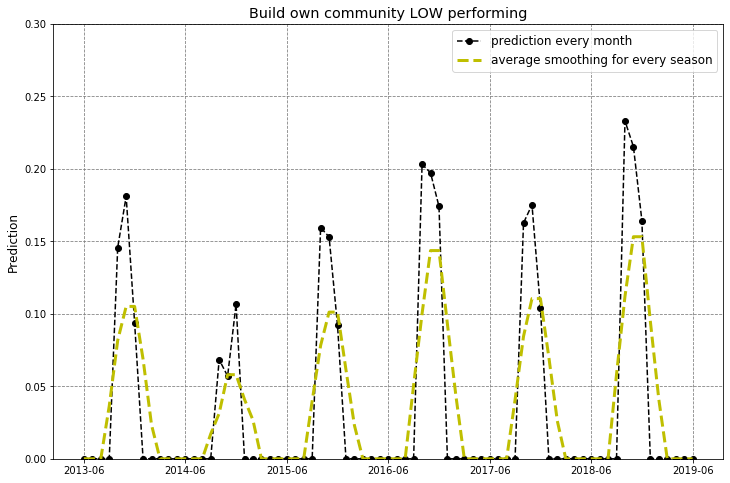

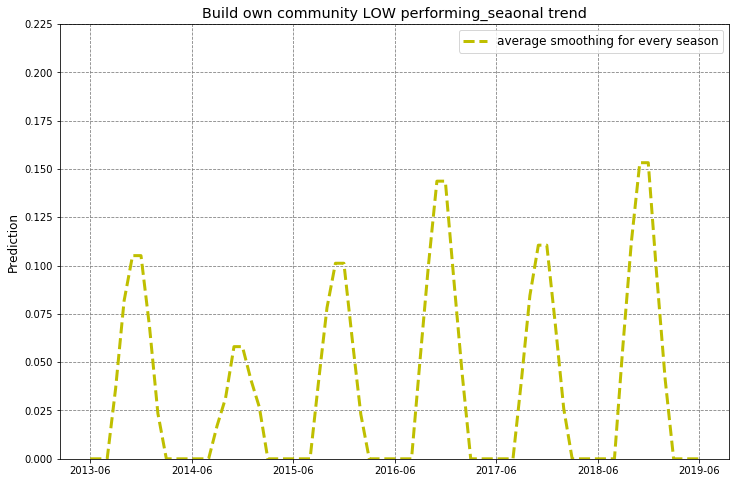

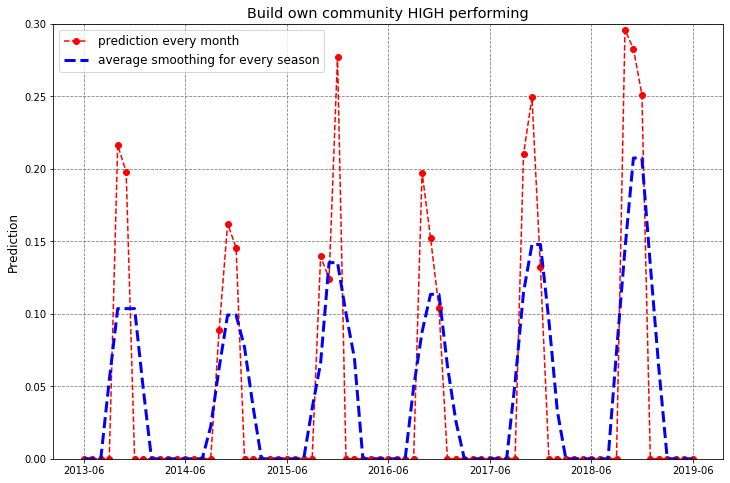

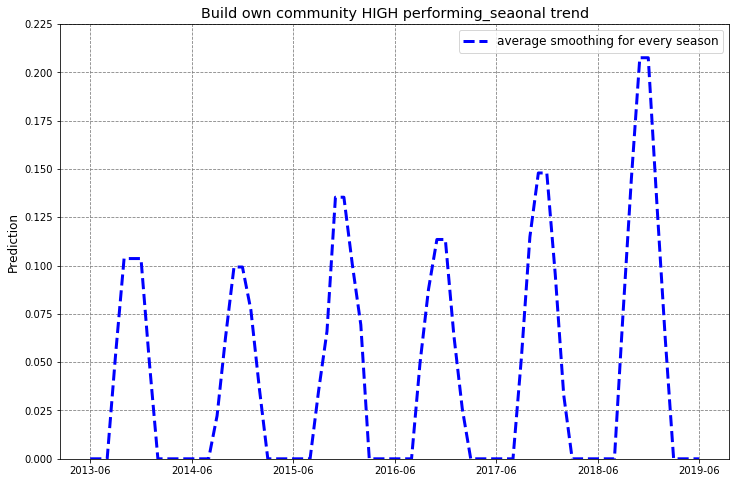

In [647]:
category = 'Build own community'
# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure_aug(category=category,path=path,month_lst=month_low_lst,\
                result_lst=result_low_lst,title_text='LOW performing',ymax=0.3)
plot_figure_aug(category=category,path=path,month_lst=month_high_lst,\
                result_lst=result_high_lst,title_text='HIGH performing',ymax=0.3)

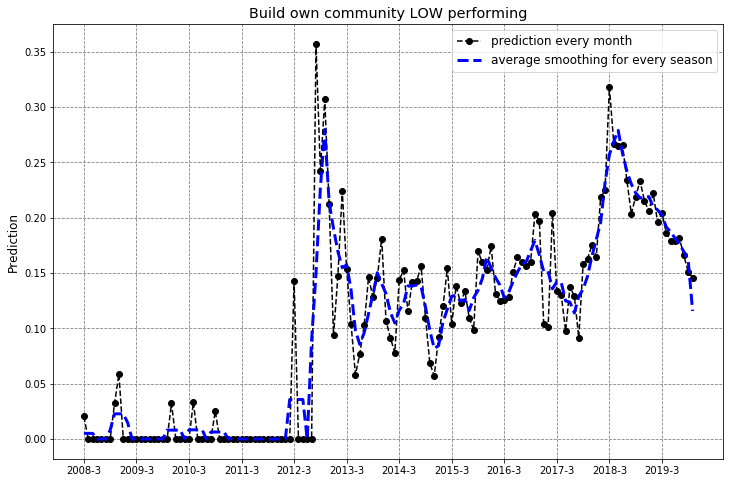

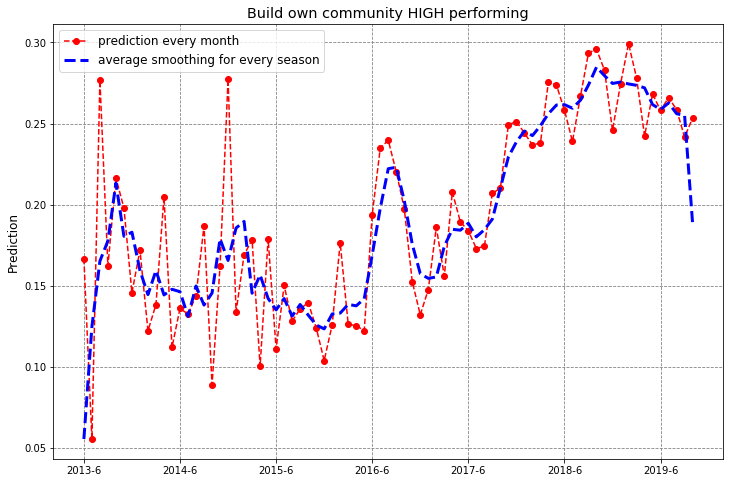

In [36]:
category = 'Build own community'
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)
plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')

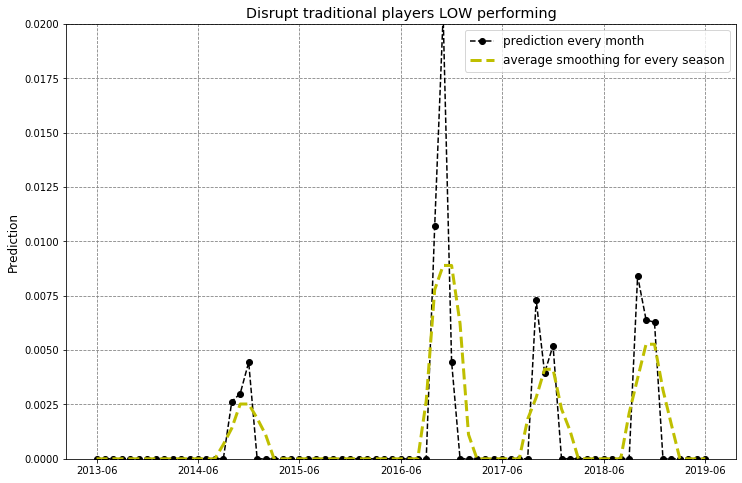

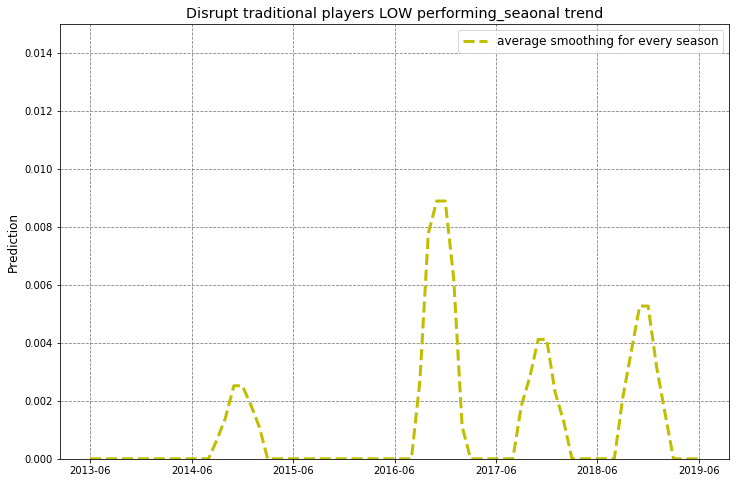

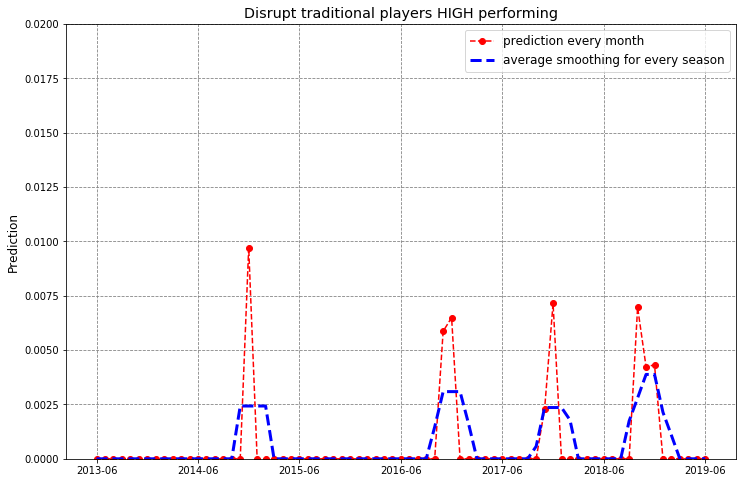

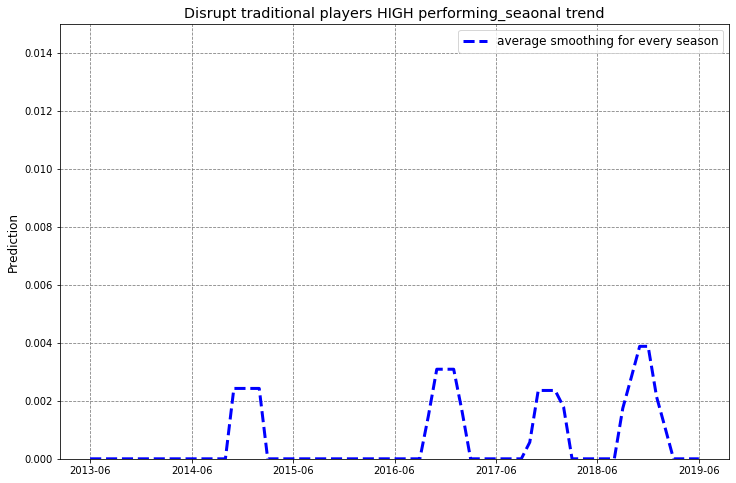

In [641]:
category = 'Disrupt traditional players'
# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure_aug(category=category,path=path,month_lst=month_low_lst,\
                result_lst=result_low_lst,title_text='LOW performing',ymax=0.02)
plot_figure_aug(category=category,path=path,month_lst=month_high_lst,\
                result_lst=result_high_lst,title_text='HIGH performing',ymax=0.02)

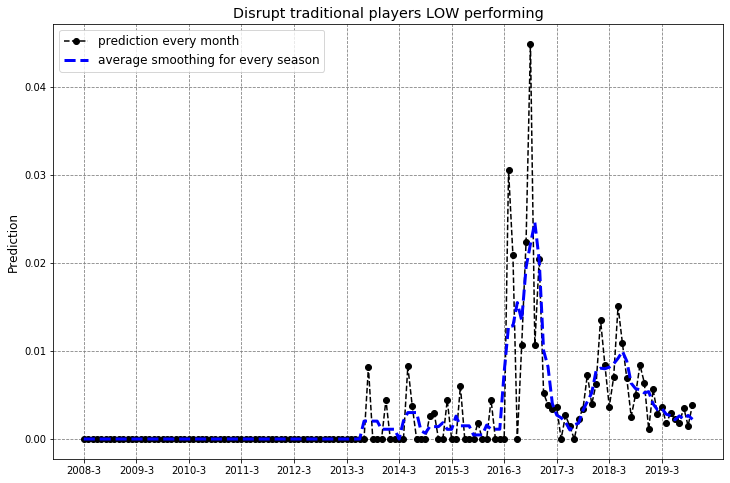

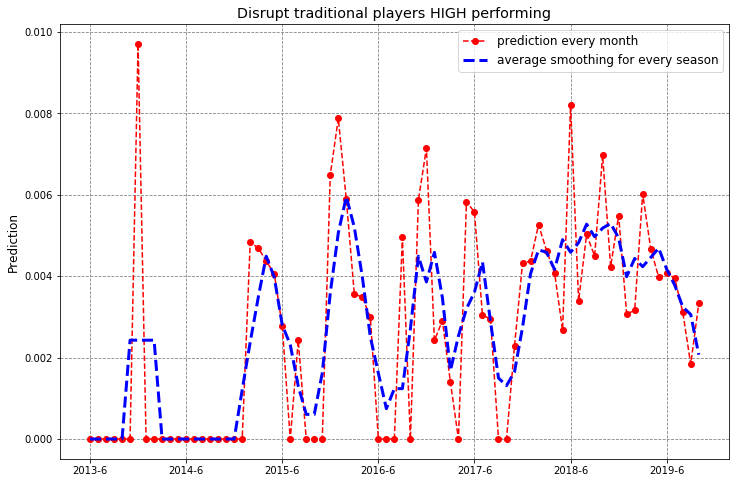

In [37]:
category = 'Disrupt traditional players'
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)
plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')

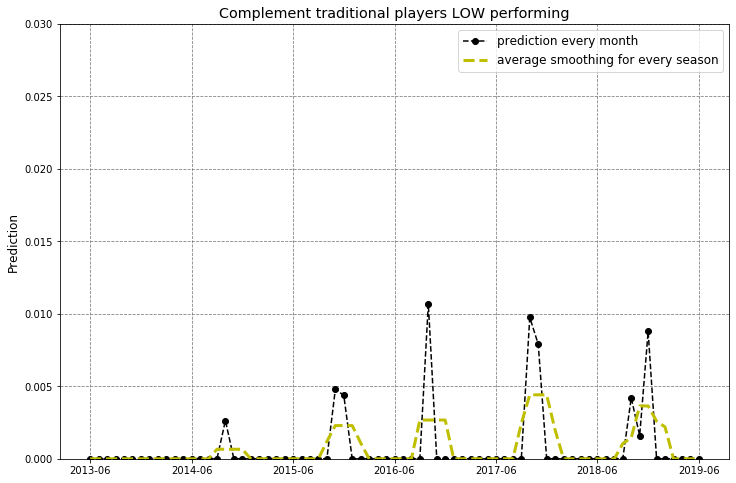

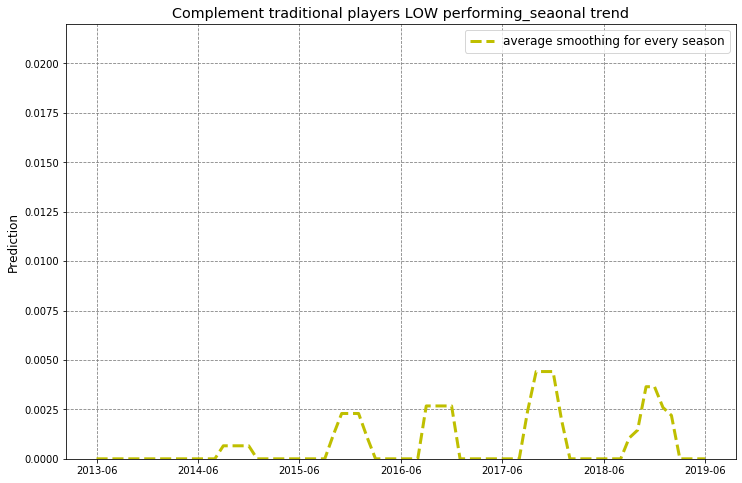

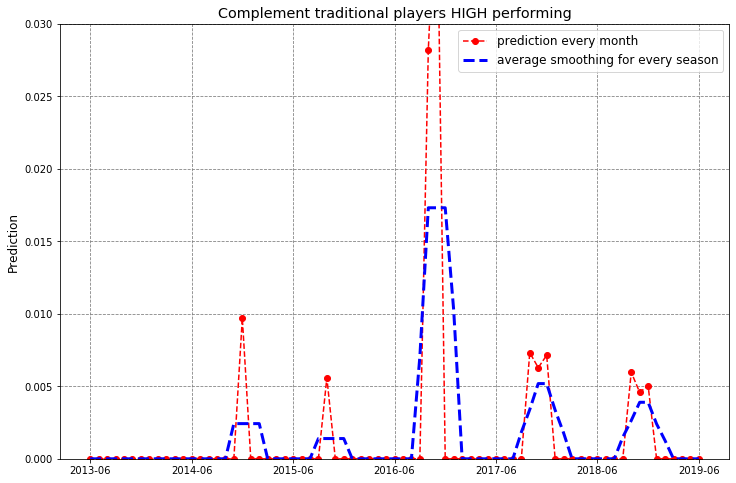

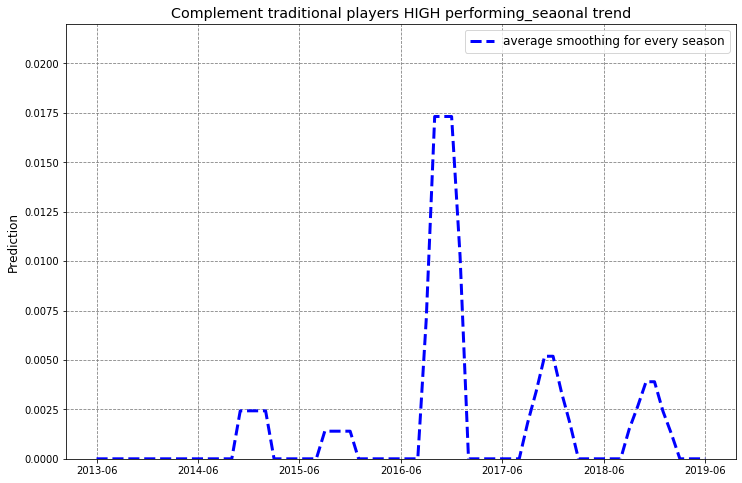

In [639]:
category = 'Complement traditional players'
# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure_aug(category=category,path=path,month_lst=month_low_lst,\
                result_lst=result_low_lst,title_text='LOW performing',ymax=0.03)
plot_figure_aug(category=category,path=path,month_lst=month_high_lst,\
                result_lst=result_high_lst,title_text='HIGH performing',ymax=0.03)

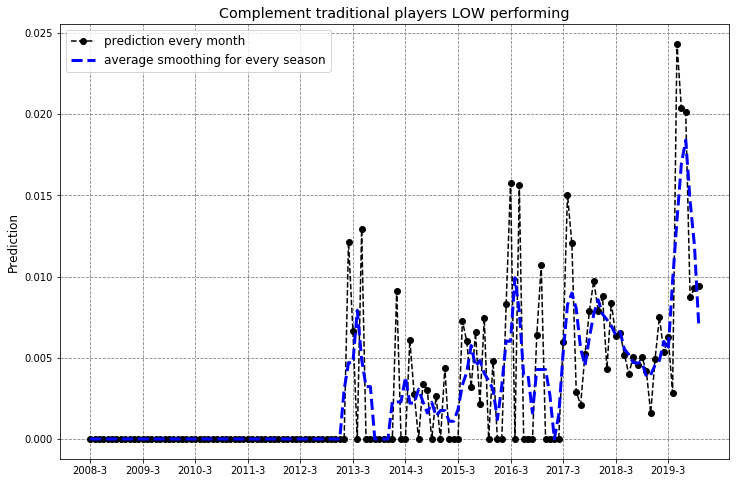

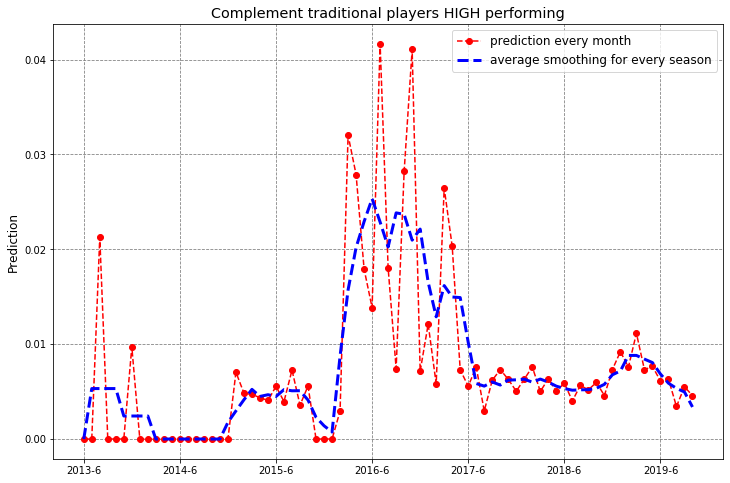

In [38]:
category = 'Complement traditional players'
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)
plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')

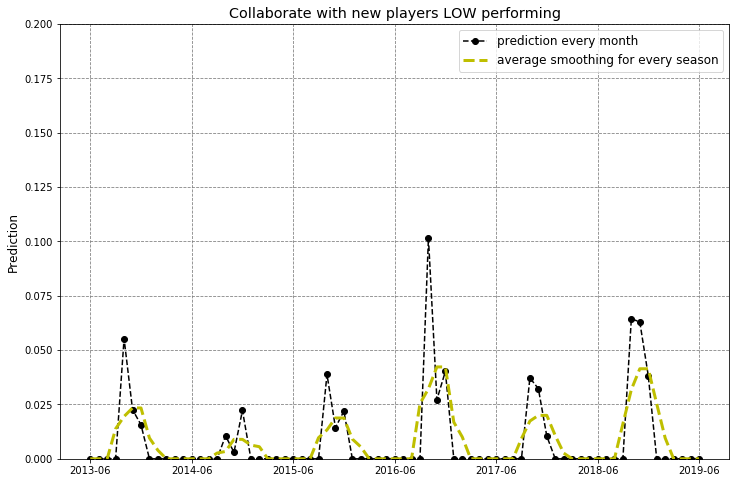

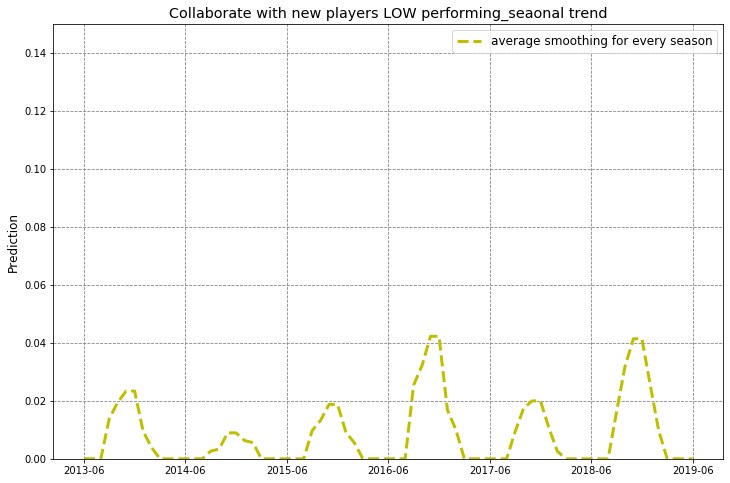

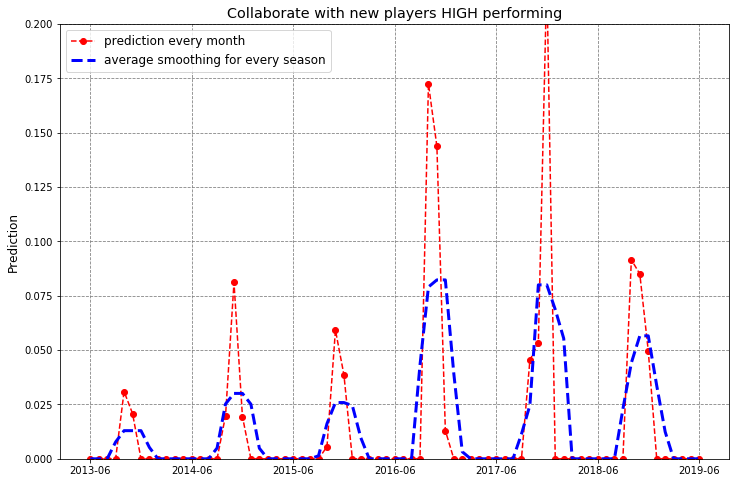

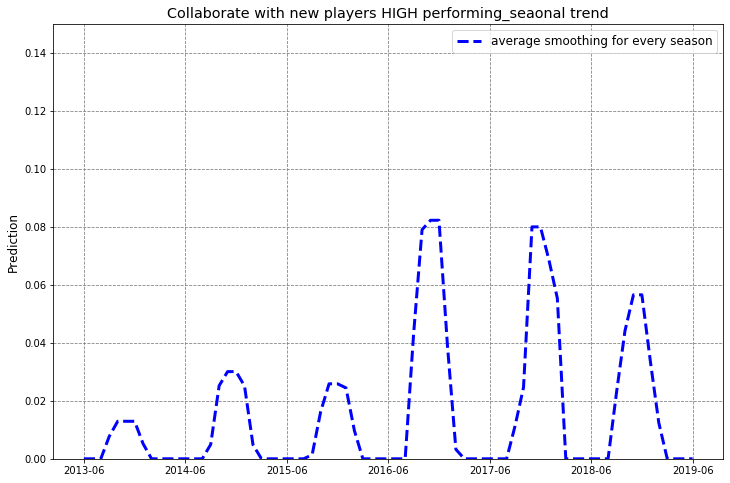

In [636]:
category = 'Collaborate with new players'
# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure_aug(category=category,path=path,month_lst=month_low_lst,\
                result_lst=result_low_lst,title_text='LOW performing',ymax=0.2)
plot_figure_aug(category=category,path=path,month_lst=month_high_lst,\
                result_lst=result_high_lst,title_text='HIGH performing',ymax=0.2)

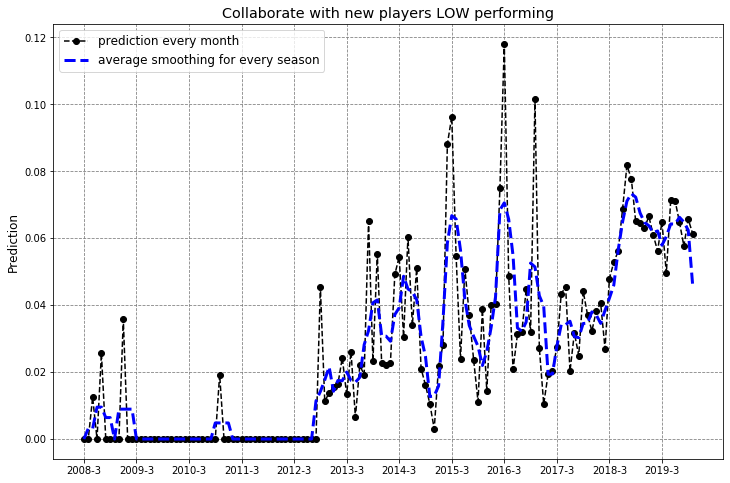

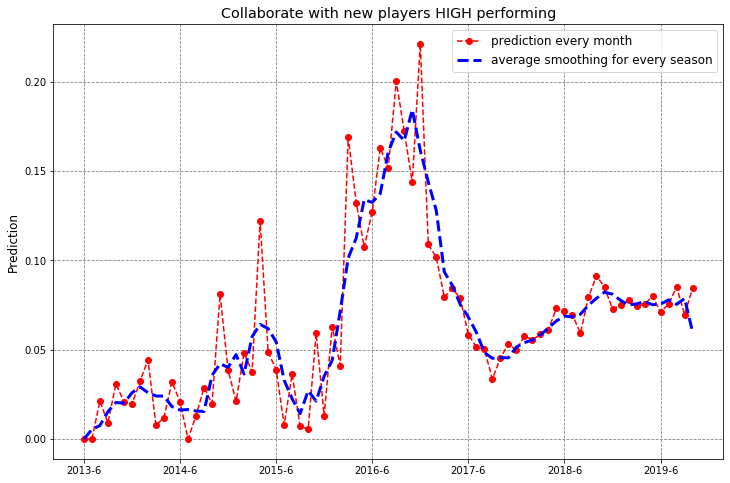

In [39]:
category = 'Collaborate with new players'
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)
plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')

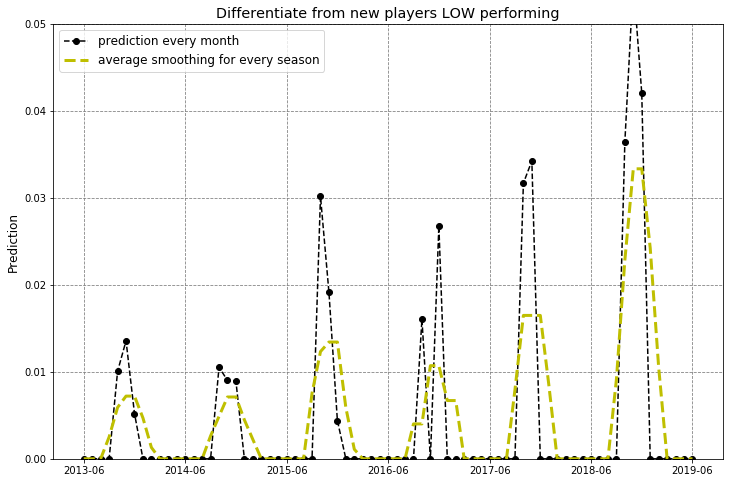

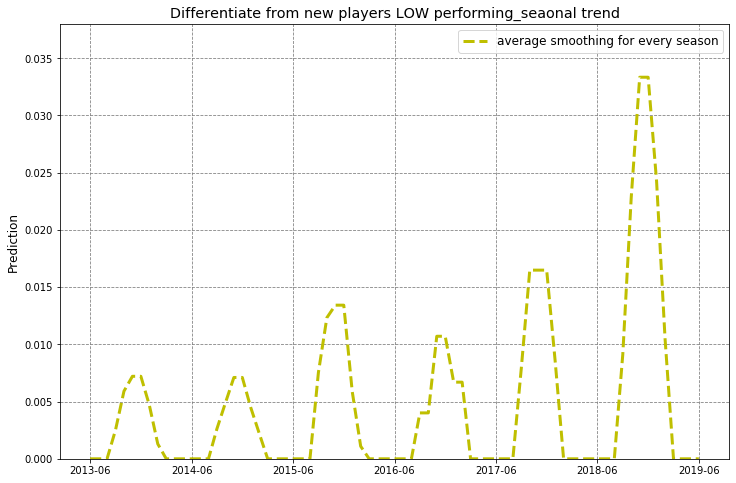

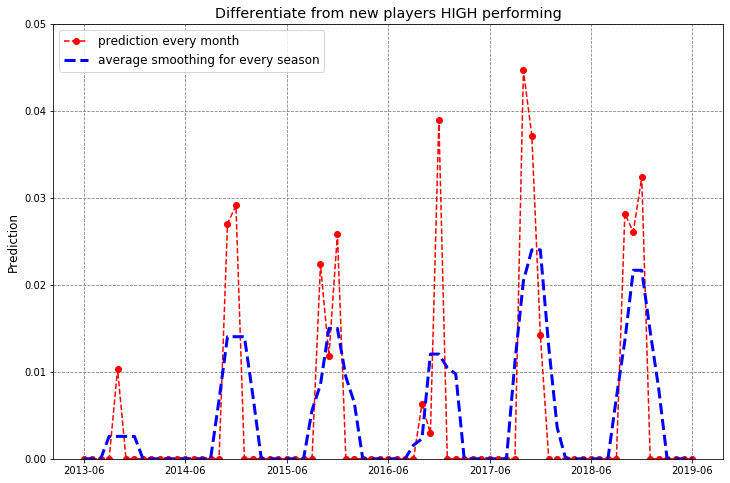

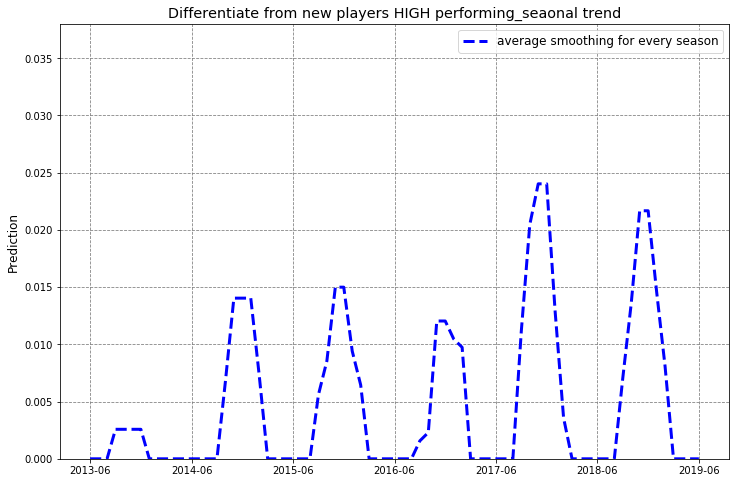

In [624]:
category = 'Differentiate from new players'
# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure_aug(category=category,path=path,month_lst=month_low_lst,\
                result_lst=result_low_lst,title_text='LOW performing',ymax=0.05)
plot_figure_aug(category=category,path=path,month_lst=month_high_lst,\
                result_lst=result_high_lst,title_text='HIGH performing',ymax=0.05)

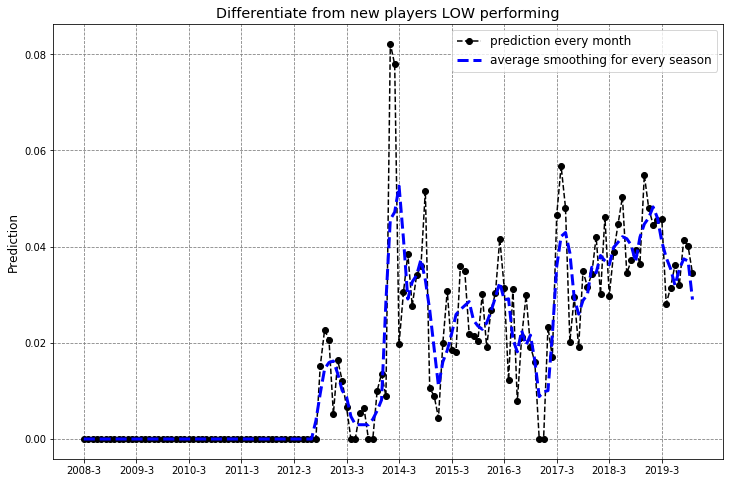

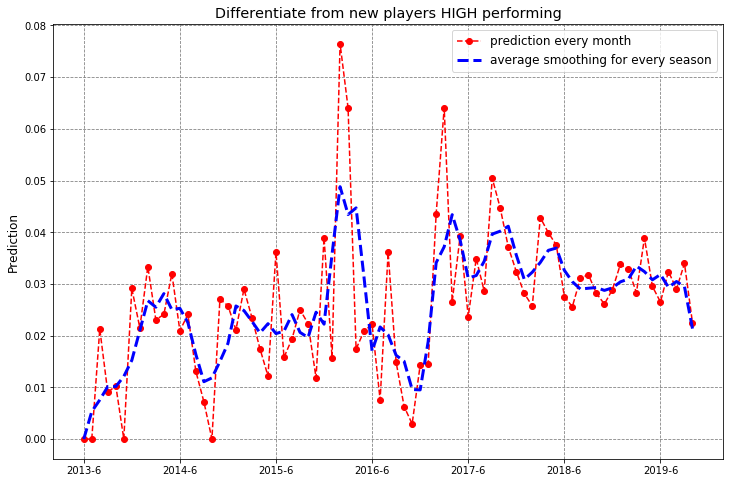

In [40]:
category = 'Differentiate from new players'
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)
plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')

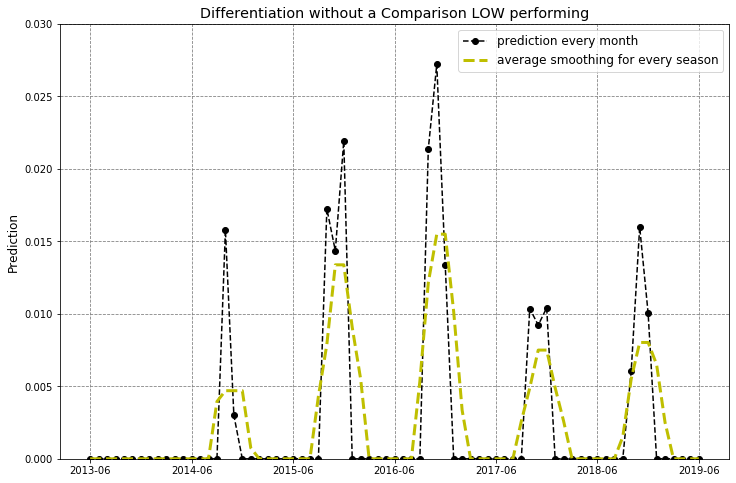

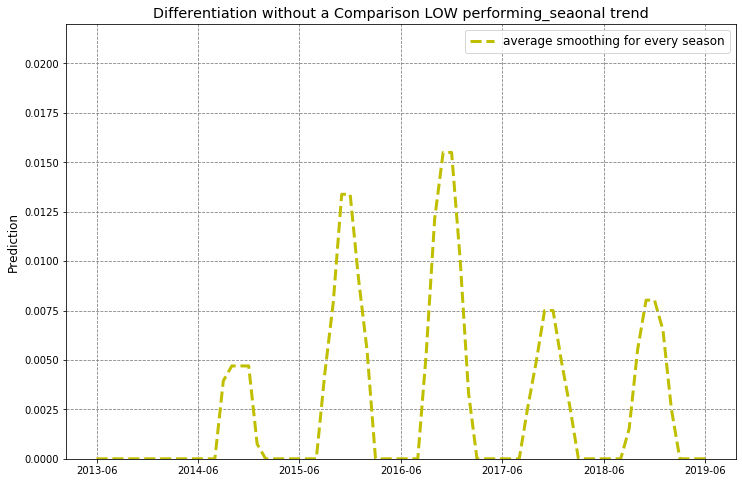

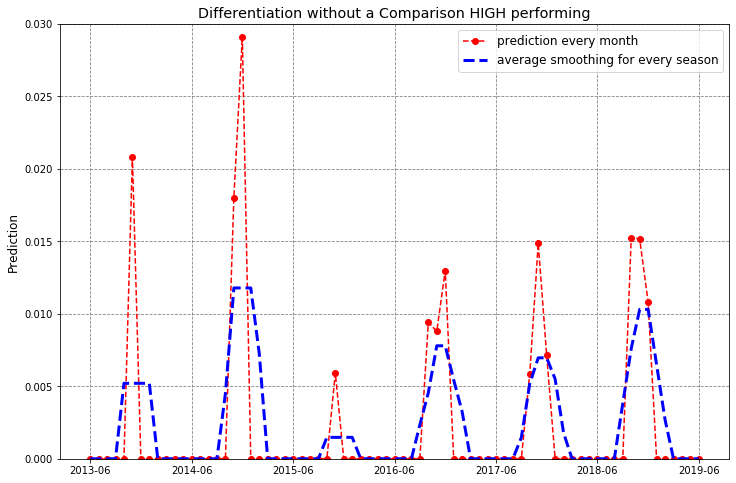

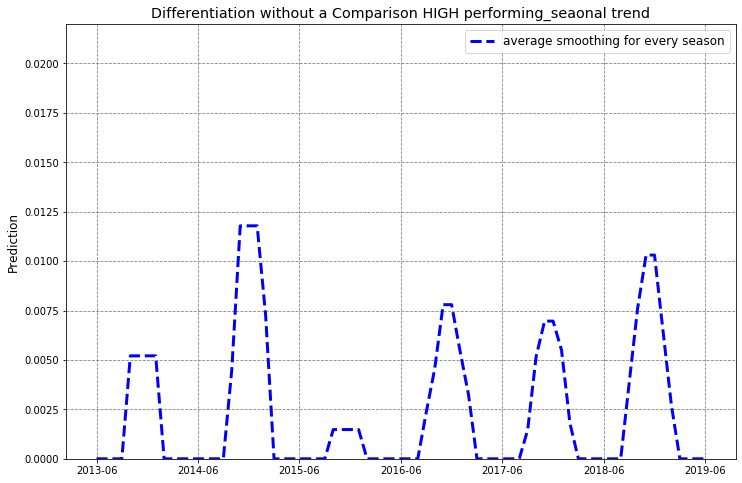

In [625]:
category = 'Differentiation without a Comparison'
# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure_aug(category=category,path=path,month_lst=month_low_lst,\
                result_lst=result_low_lst,title_text='LOW performing',ymax=0.03)
plot_figure_aug(category=category,path=path,month_lst=month_high_lst,\
                result_lst=result_high_lst,title_text='HIGH performing',ymax=0.03)

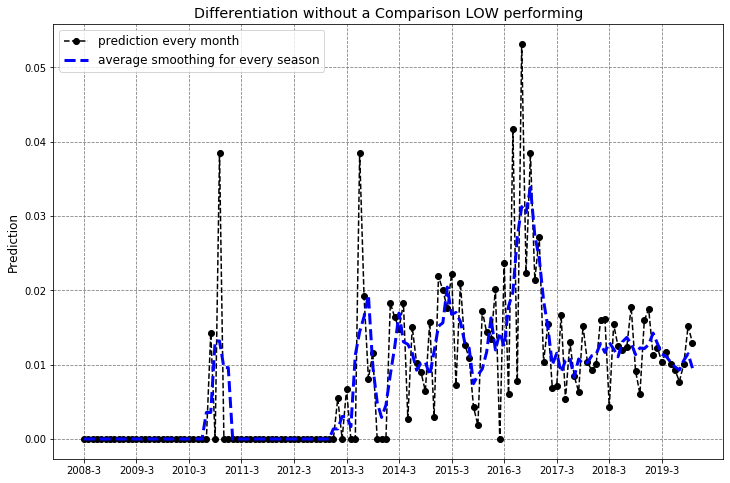

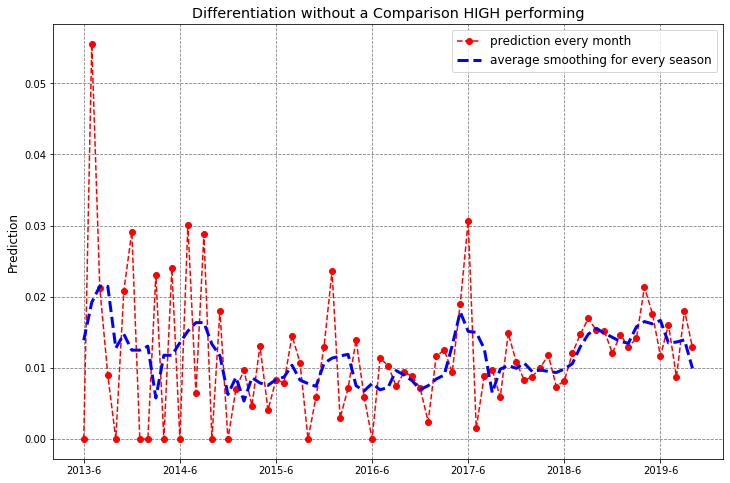

In [41]:
category = 'Differentiation without a Comparison'
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)
plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')

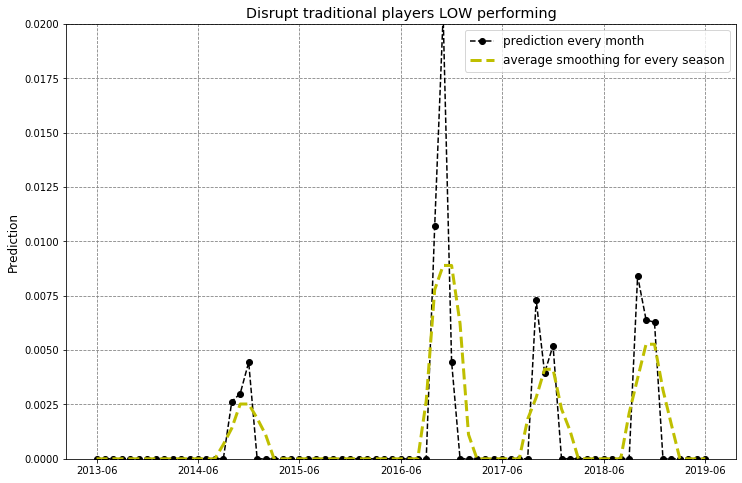

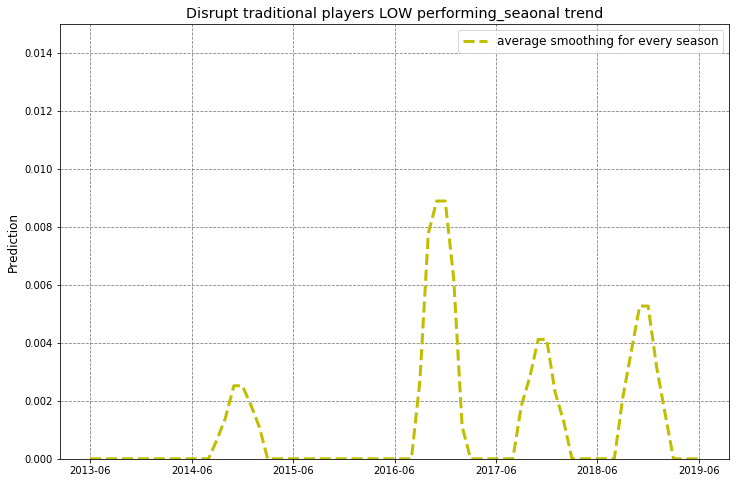

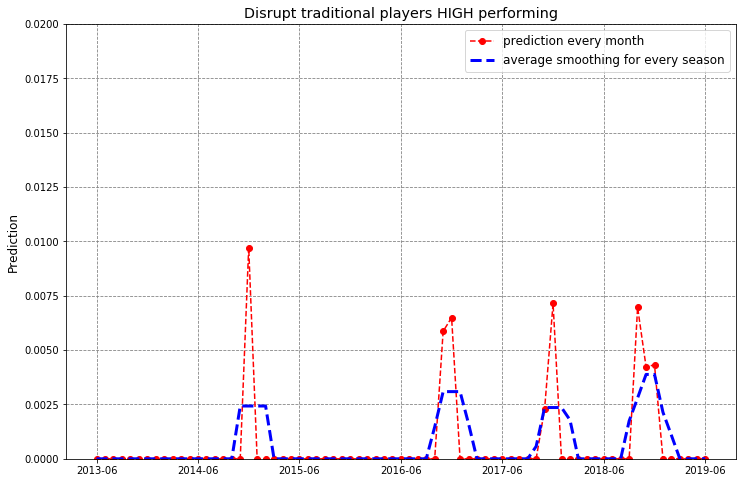

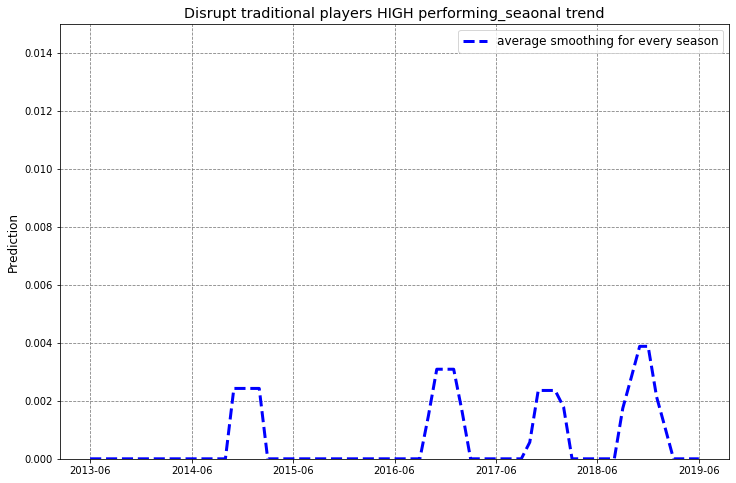

In [627]:
category = 'Disrupt traditional players'
# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure_aug(category=category,path=path,month_lst=month_low_lst,\
                result_lst=result_low_lst,title_text='LOW performing',ymax=0.02)
plot_figure_aug(category=category,path=path,month_lst=month_high_lst,\
                result_lst=result_high_lst,title_text='HIGH performing',ymax=0.02)

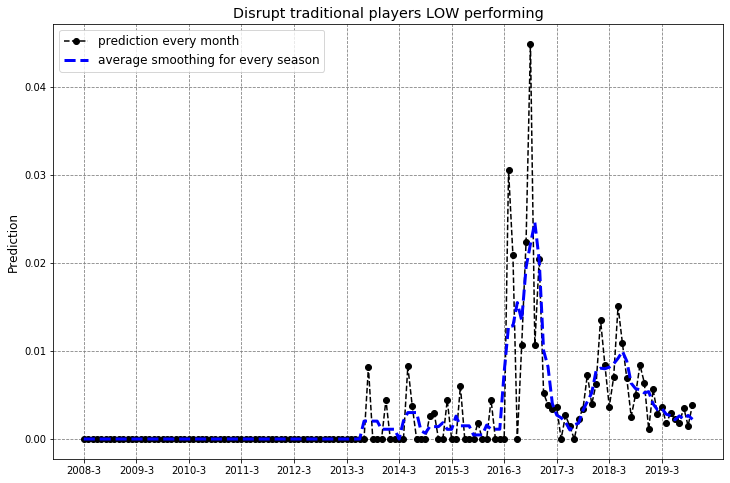

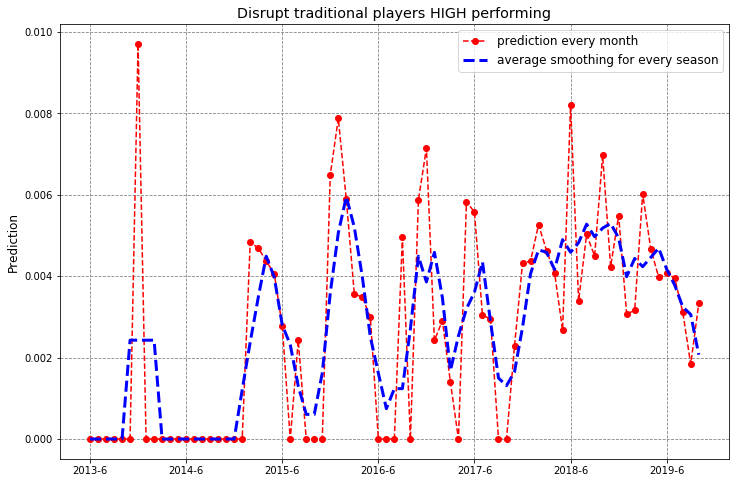

In [42]:
category = 'Disrupt traditional players'
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)
plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')

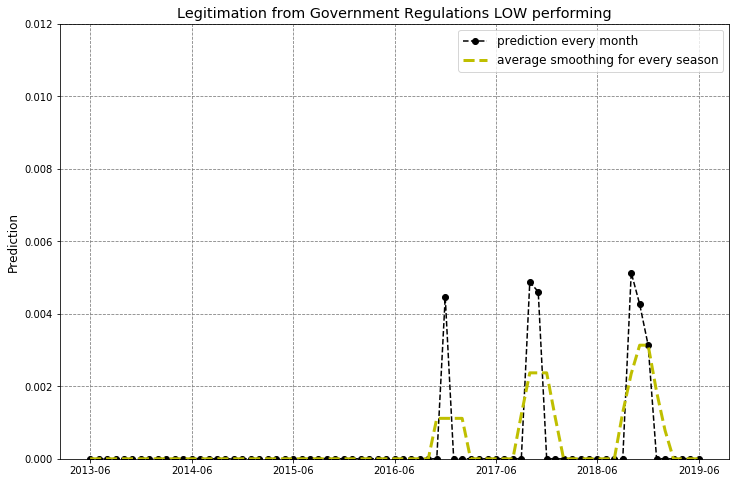

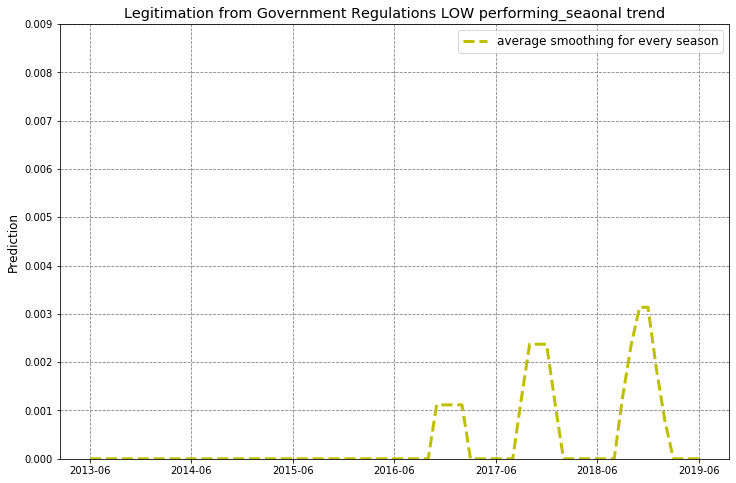

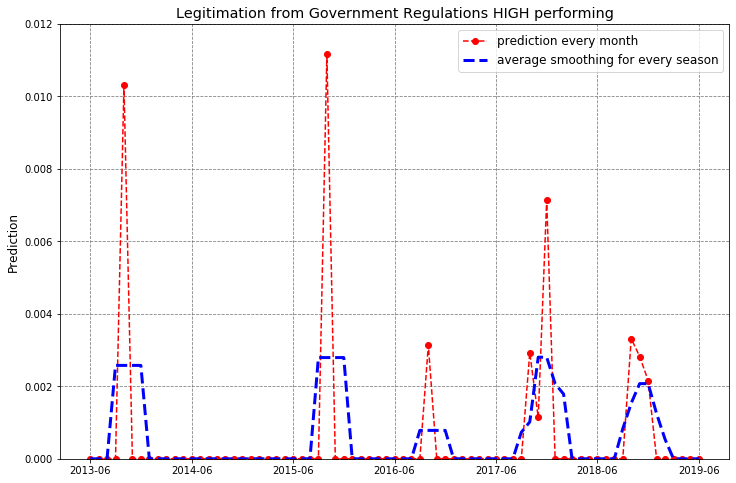

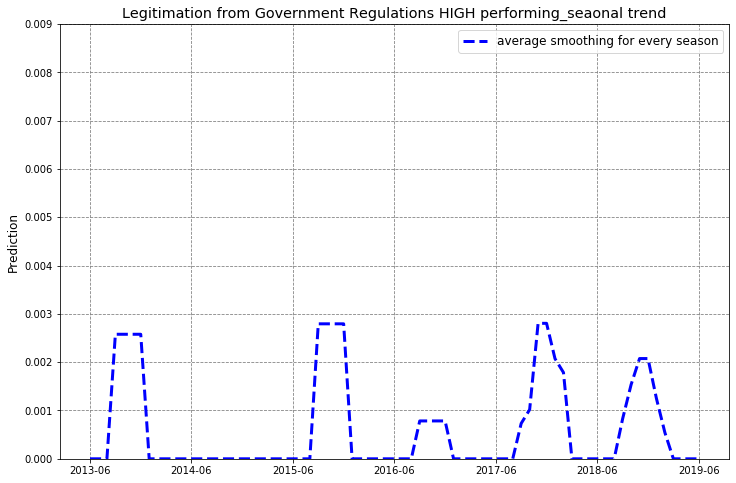

In [628]:
category = 'Legitimation from Government Regulations'
# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure_aug(category=category,path=path,month_lst=month_low_lst,\
                result_lst=result_low_lst,title_text='LOW performing',ymax=0.012)
plot_figure_aug(category=category,path=path,month_lst=month_high_lst,\
                result_lst=result_high_lst,title_text='HIGH performing',ymax=0.012)

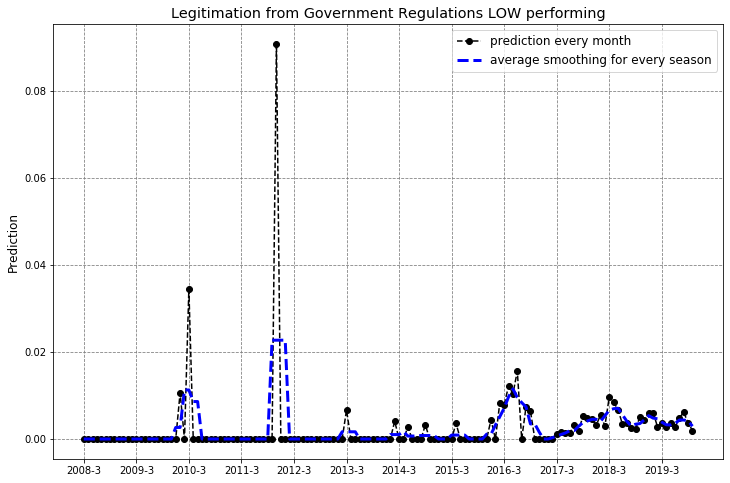

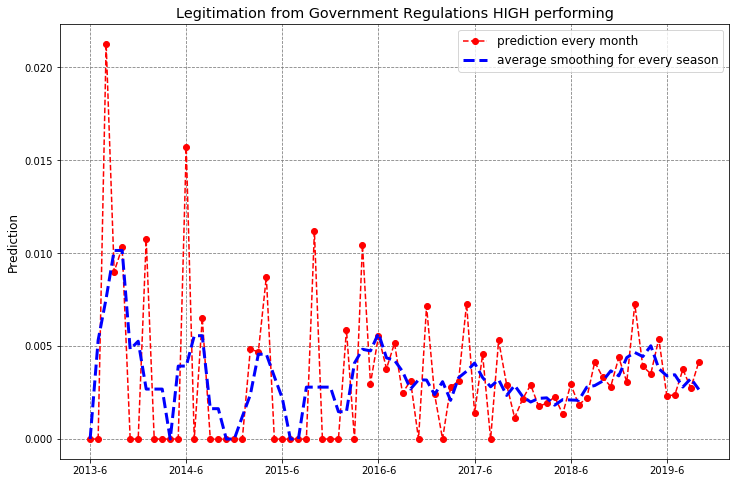

In [43]:
category = 'Legitimation from Government Regulations'
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)
plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')

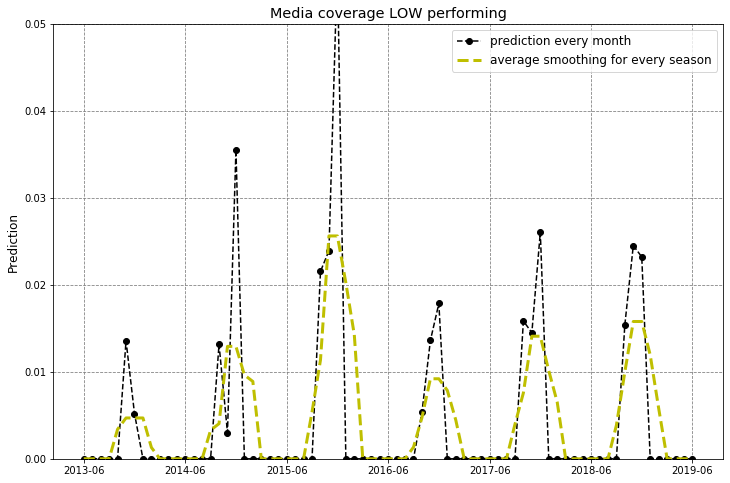

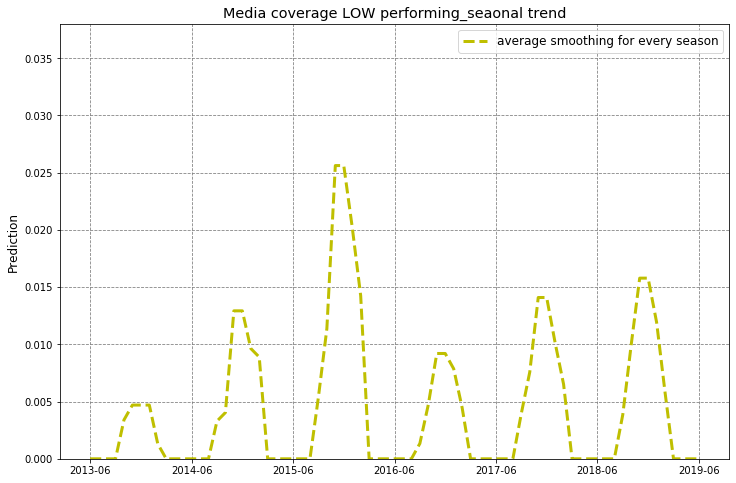

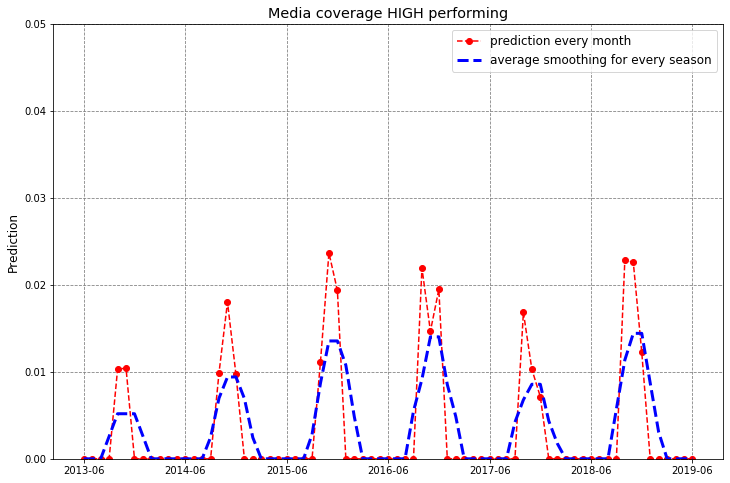

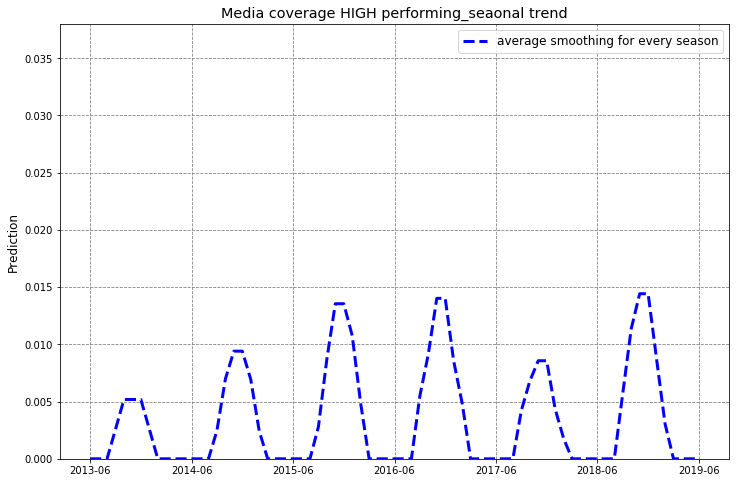

In [629]:
category = 'Media coverage'
# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure_aug(category=category,path=path,month_lst=month_low_lst,\
                result_lst=result_low_lst,title_text='LOW performing',ymax=0.05)
plot_figure_aug(category=category,path=path,month_lst=month_high_lst,\
                result_lst=result_high_lst,title_text='HIGH performing',ymax=0.05)

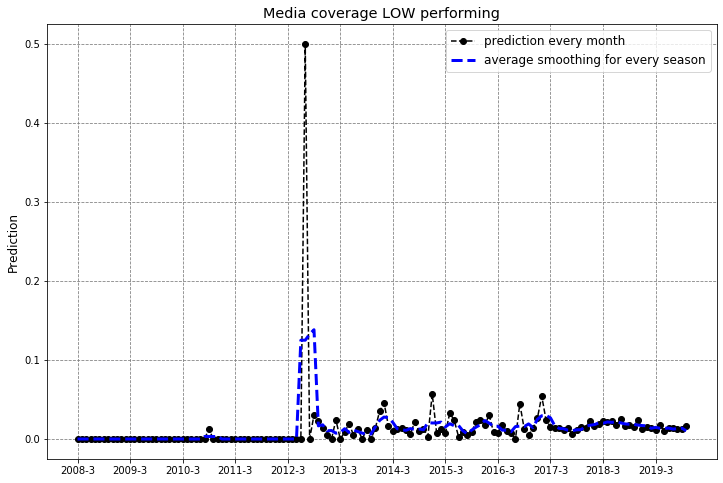

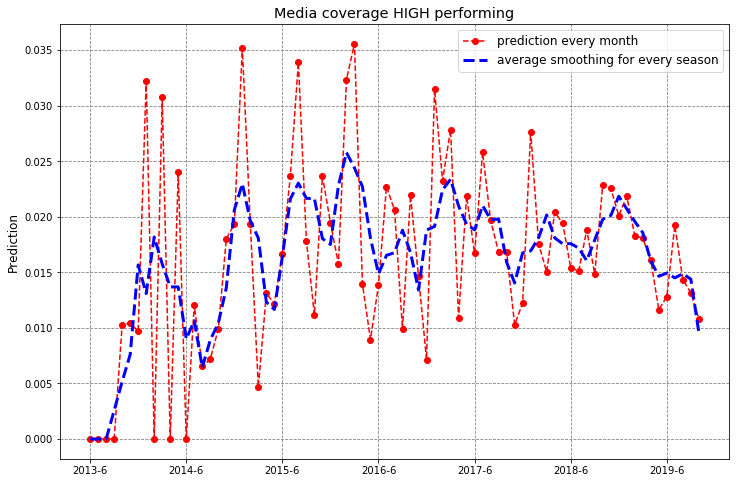

In [44]:
category = 'Media coverage'
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)
plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')

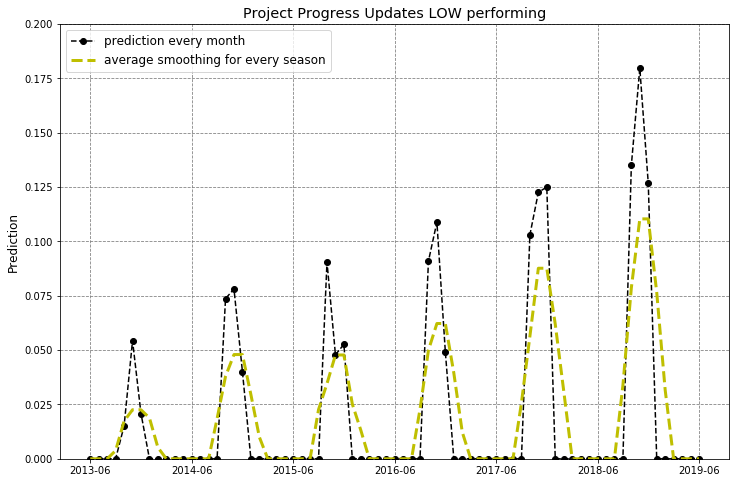

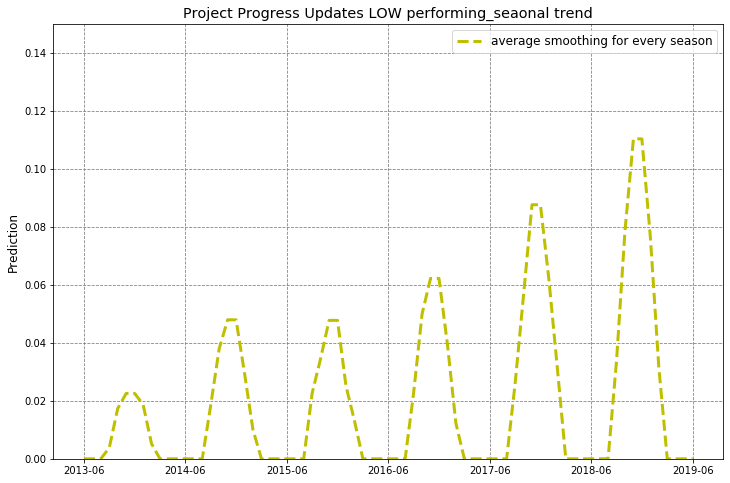

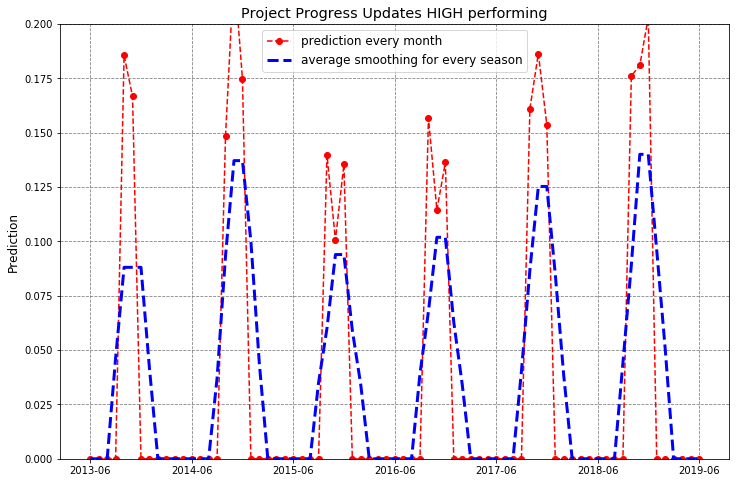

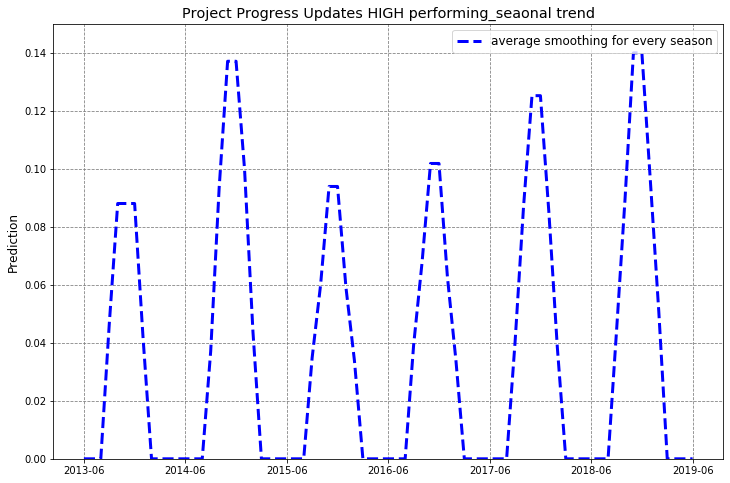

In [632]:
category = 'Project Progress Updates'
# referred from
# https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)

plot_figure_aug(category=category,path=path,month_lst=month_low_lst,\
                result_lst=result_low_lst,title_text='LOW performing',ymax=0.2)
plot_figure_aug(category=category,path=path,month_lst=month_high_lst,\
                result_lst=result_high_lst,title_text='HIGH performing',ymax=0.2)

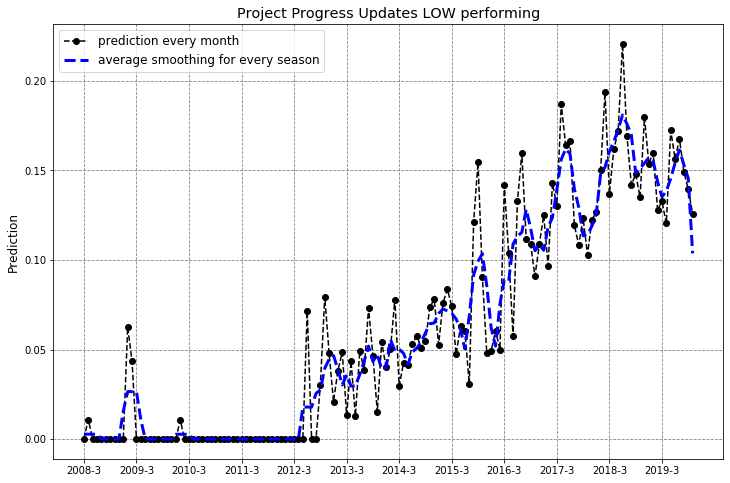

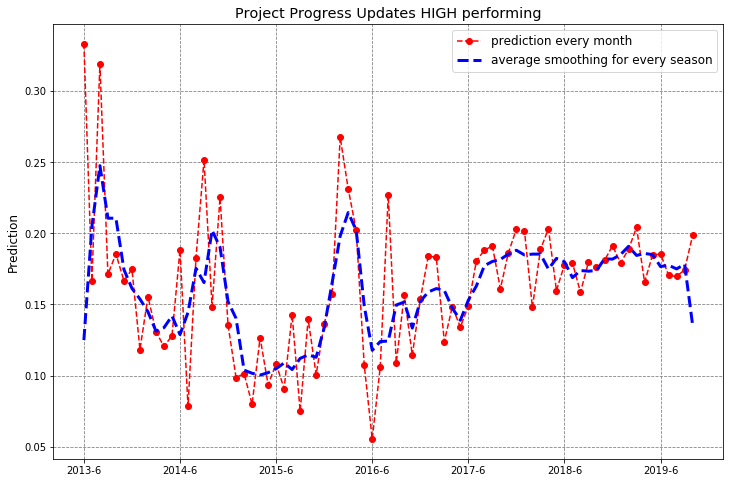

In [45]:
category = 'Project Progress Updates'
file = open(path + category + '_plot.pkl', 'rb')
month_low_lst = pickle.load(file)
month_high_lst = pickle.load(file)
result_low_lst = pickle.load(file)
result_high_lst = pickle.load(file)
plot_figure(category=category,path=path,month_lst=month_low_lst,result_lst=result_low_lst,title_text='LOW performing')
plot_figure(category=category,path=path,month_lst=month_high_lst,result_lst=result_high_lst,title_text='HIGH performing')